In [2]:
import xarray as xr
import matplotlib as mpl
import numpy as np

In [61]:
#read monthly Temperature and relative humidity data
dir = '/home/bernatj/Data/my_data/era5/monthly/'

rh = xr.open_mfdataset(dir+'rh/rh-*.nc').r
t = xr.open_mfdataset(dir+'t/t-*.nc').t
t2m = xr.open_mfdataset(dir+'t2m/t2m-*.nc').t2m
tcwv = xr.open_mfdataset(dir+'tcwv/tcwv-*.nc').tcwv

ds_pl = xr.merge([t,rh])
ds_sl = xr.merge([t2m, tcwv])

In [3]:
#levels to interpolate
levels =  [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
period_1 = slice('1940-01-01','1970-12-31')
period_2 = slice('1992-01-01','2022-12-31')


In [63]:
#surface vars

for var in ['t2m', 'tcwv']:
    var_clim_period1 = ds_sl[var].sel(time=period_1).groupby('time.month').mean('time')
    var_clim_period2 = ds_sl[var].sel(time=period_2).groupby('time.month').mean('time') 
    var_diff = var_clim_period2 - var_clim_period1

    var_diff.to_netcdf(f'{var}_delta_era5_1940to1970_1992to2022.nc',mode='w')
    


In [27]:
#pressure vars

for var in ['t', 'r']:
    var_clim_period1 = ds_pl[var].sel(time=period_1).groupby('time.month').mean('time')
    var_clim_period2 = ds_pl[var].sel(time=period_2).groupby('time.month').mean('time') 
    var_diff = var_clim_period2 - var_clim_period1

    var_diff.to_netcdf(f'{var}_delta_era5_1940to1970_1992to2022.nc',mode='w')

In [64]:
#interpolate to daily values
t2m_delta_moncli = xr.open_dataset('t2m_delta_era5_1940to1970_1992to2022.nc').t2m
tcwv_delta_moncli = xr.open_dataset('tcwv_delta_era5_1940to1970_1992to2022.nc').tcwv

In [65]:
def interpolate_to_daily_climatology(data, method='cubic'):
    """
    Interpolates monthly climatology data to daily climatology data.
    
    Parameters:
        data (xarray.Dataset or xarray.DataArray): Monthly climatology dataset or array.
        method (str, optional): Interpolation method. Default is 'cubic'.
        
    Returns:
        xarray.Dataset or xarray.DataArray: Daily climatology dataset or array.
    """
    # Number of days per month
    num_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    # Calculate the center day of each month
    dayofyear = [(num_days[i] // 2) + 1 + sum(num_days[0:i]) for i in range(0, 12)]
    

    # Rename 'month' dimension to 'dayofyear'
    data = data.rename({'month': 'dayofyear'})
        
    # Assign new coordinates for 'dayofyear'
    data = data.assign_coords({'dayofyear': dayofyear})
        
    # Interpolate to daily resolution
    data_interpolated = data.interp(dayofyear=np.arange(1, 366), method=method)

    return data_interpolated


In [66]:
tcwv_delta_dayclim = interpolate_to_daily_climatology(tcwv_delta_moncli)
t2m_delta_dayclim = interpolate_to_daily_climatology(t2m_delta_moncli)

In [29]:
#now let's do the same but for pressue variables

t_delta_moncli = xr.open_dataset('t_delta_era5_1940to1970_1992to2022.nc').t
r_delta_moncli = xr.open_dataset('r_delta_era5_1940to1970_1992to2022.nc').r

t_delta_moncli = t_delta_moncli.interp(level=levels)
r_delta_moncli = r_delta_moncli.interp(level=levels)

t_delta_dayclim = interpolate_to_daily_climatology(t_delta_moncli)
r_delta_dayclim = interpolate_to_daily_climatology(r_delta_moncli)

In [31]:
t_delta_dayclim.to_netcdf('t_delta_era5_dayclim.nc')
r_delta_dayclim.to_netcdf('r_delta_era5_dayclim.nc')

In [32]:
t_delta_dayclim = xr.open_dataset('t_delta_era5_dayclim.nc')
r_delta_dayclim = xr.open_dataset('r_delta_era5_dayclim.nc')

In [67]:
#choose the dayofyear and apply the delta:

#input to modify

input_sl_data = xr.open_dataset('/home/bernatj/Data/ai-forecasts/input/grib/fcnv2sm_sl_20180731.grib', engine='cfgrib')
input_sl_data

<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    valid_time  datetime64[ns] ...
Data variables:
    sp          (latitude, longitude) float32 ...
    v100        (latitude, longitude) float32 ...
    msl         (latitude, longitude) float32 ...
    u100        (latitude, longitude) float32 ...
    u10         (latitude, longitude) float32 ...
    t2m         (latitude, longitude) float32 ...
    tcwv        (latitude, longitude) float32 ...
    v10         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-02-28T17:25 GRIB to CDM+CF via cfgrib-0.9.1...

In [68]:
import datetime as dt

# Create a datetime object for the input date
date_object = dt.datetime(2018, 7, 31)
    
# Get the day of the year from the datetime object
day_of_year = date_object.timetuple().tm_yday
day_of_year

212

In [70]:
input_sl_data = input_sl_data.assign_coords(longitude=input_sl_data["longitude"] % 360)
input_sl_data= input_sl_data.sortby("longitude")

input_sl_data['t2m'] = input_sl_data['t2m'] - t2m_delta_dayclim.sel(dayofyear=day_of_year)
input_sl_data['tcwv'] = input_sl_data['tcwv'] - tcwv_delta_dayclim.sel(dayofyear=day_of_year)

#input_sl_data = input_sl_data.drop_vars('lon')

In [71]:
import os

os.remove('/home/bernatj/Data/ai-forecasts/input/netcdf/fcnv2sm_sl_20180731_modified_era5_delta_2.nc')

input_sl_data.to_netcdf('/home/bernatj/Data/ai-forecasts/input/netcdf/fcnv2sm_sl_20180731_modified_era5_delta_2.nc')

In [33]:
#for pressure level data

input_pl_data = xr.open_dataset('/home/bernatj/Data/ai-forecasts/input/grib/fcnv2sm_pl_20180731.grib', engine='cfgrib')
input_pl_data

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 13, latitude: 721, longitude: 1440)
Coordinates:
    number         int64 ...
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 925.0 850.0 ... 100.0 50.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     datetime64[ns] ...
Data variables:
    u              (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
    z              (isobaricInhPa, latitude, longitude) float32 ...
    v              (isobaricInhPa, latitude, longitude) float32 ...
    r              (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-02-28T16:16 GRIB to CDM+CF via cfgrib-0.9.1...

In [41]:
t_delta_dayclim.sel(dayofyear=day_of_year)['t'].sel(latitude=45,longitude=5).values

array([ 1.79085595,  1.87217431,  1.73113309,  1.03638921,  0.84229907,
        1.214465  ,  1.1502737 ,  0.87145476,  0.09122353, -0.73736657,
       -0.18553075, -1.26112809, -1.59967742])

In [42]:
input_pl_data = input_pl_data.assign_coords(longitude=input_pl_data["longitude"] % 360)
input_pl_data= input_pl_data.sortby("longitude")


input_pl_data['t'] = input_pl_data['t'] - t_delta_dayclim.sel(dayofyear=day_of_year)['t'].rename({'level' : 'isobaricInhPa'})
input_pl_data['r'] = input_pl_data['r'] - r_delta_dayclim.sel(dayofyear=day_of_year)['r'].rename({'level' : 'isobaricInhPa'})


In [44]:
input_pl_data.t.values 

array([[[273.21852481, 273.21852481, 273.21852481, ..., 273.21852481,
         273.21852481, 273.21852481],
        [273.22033429, 273.22052354, 273.22032534, ..., 273.22028573,
         273.22026778, 273.22020324],
        [273.17320851, 273.17307104, 273.17336505, ..., 273.17324358,
         273.17320698, 273.17293584],
        ...,
        [239.84828461, 239.85363727, 239.85861628, ..., 239.83451358,
         239.84000788, 239.8433701 ],
        [240.10586335, 240.10961534, 240.11538778, ..., 240.0951394 ,
         240.09842786, 240.10254499],
        [239.94305349, 239.94305349, 239.94305349, ..., 239.94305349,
         239.94305349, 239.94305349]],

       [[267.72743875, 267.72743875, 267.72743875, ..., 267.72743875,
         267.72743875, 267.72743875],
        [268.02562699, 268.02417033, 268.02481962, ..., 268.02412244,
         268.02470701, 268.02533595],
        [268.16028073, 268.16138412, 268.16259623, ..., 268.1567075 ,
         268.15779567, 268.15923096],
        ...,


In [45]:
import os

os.remove('/home/bernatj/Data/ai-forecasts/input/netcdf/fcnv2sm_pl_20180731_modified_era5_delta_2.nc')

input_pl_data.to_netcdf('/home/bernatj/Data/ai-forecasts/input/netcdf/fcnv2sm_pl_20180731_modified_era5_delta_2.nc')

In [4]:
input_pl_data = xr.open_dataset('/home/bernatj/Data/ai-forecasts/input/netcdf/fcnv2sm_pl_20180731_modified_era5_delta_2.nc')

/home/bernatj/miniconda3/envs/bernatj-stream-env/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [81]:
import metpy 
from metpy.units import units

#input_pl_data = input_pl_data.rename({'isobaricInhPa' : 'level'})

z,t,r = input_pl_data.z, input_pl_data.t, input_pl_data.r

def adjust_geopotential(z,t,r):

    R_d = 287.05    # gas constant for dry air [J K-1 kg-1]

    pressure = z.level.broadcast_like(z)
    lnp=np.log(pressure)

    #calculate mixing ratio from relative humidity
    w = metpy.calc.mixing_ratio_from_relative_humidity(pressure * units.hPa , t * units.K , r/100)

    #calculate virtual temperature
    tv = metpy.calc.virtual_temperature(t*units.K, w).values
   
    z_new = z.copy()

    #let's now integrate with hight using the hydrostatic balance and ideal gas law
    for k in range(0,len(z.level)-1,1):
        #z_new[k+1] = z_new[k] - (np.log(pressure[k+1]*100) - np.log(pressure[k]*100)) * R_d * (tv[k+1] + tv[k]) * 0.5
        tv_k12 = (tv[k]*lnp[k] + t[k+1]*lnp[k+1])/(lnp[k] + lnp[k+1])
        #tv_k12 = (tv[k]+ t[k+1])/2
        print(tv_k12)
        z_new[k+1] = z_new[k] - (lnp[k+1] - lnp[k]) * R_d * tv_k12

    return z_new
    
z_adjust = adjust_geopotential(z,t,r)

z_diff = z_adjust - z

<xarray.DataArray (latitude: 721, longitude: 1440)>
array([[270.78381583, 270.78381583, 270.78381583, ..., 270.78381583,
        270.78381583, 270.78381583],
       [270.9375422 , 270.9369112 , 270.93711076, ..., 270.93679894,
        270.93707535, 270.93734758],
       [270.98761928, 270.98805894, 270.98878135, ..., 270.9859398 ,
        270.98643879, 270.98697569],
       ...,
       [238.11753114, 238.12282988, 238.12707926, ..., 238.10452573,
        238.10904315, 238.11329029],
       [238.34135647, 238.34506617, 238.34974793, ..., 238.33040324,
        238.33389372, 238.33778132],
       [238.25540189, 238.25540189, 238.25540189, ..., 238.25540189,
        238.25540189, 238.25540189]])
Coordinates:
    number      int64 0
    time        datetime64[ns] 2018-07-31
    step        timedelta64[ns] 00:00:00
    valid_time  datetime64[ns] 2018-07-31
    dayofyear   int64 212
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) flo

In [92]:
import os

input_pl_data['z'] = z_adjust
input_pl_data = input_pl_data.rename({'level' : 'isobaricInhPa'})

os.remove('/home/bernatj/Data/ai-forecasts/input/netcdf/fcnv2sm_pl_20180731_modified_era5_delta_zadjust.nc')
input_pl_data.to_netcdf('/home/bernatj/Data/ai-forecasts/input/netcdf/fcnv2sm_pl_20180731_modified_era5_delta_zadjust.nc')

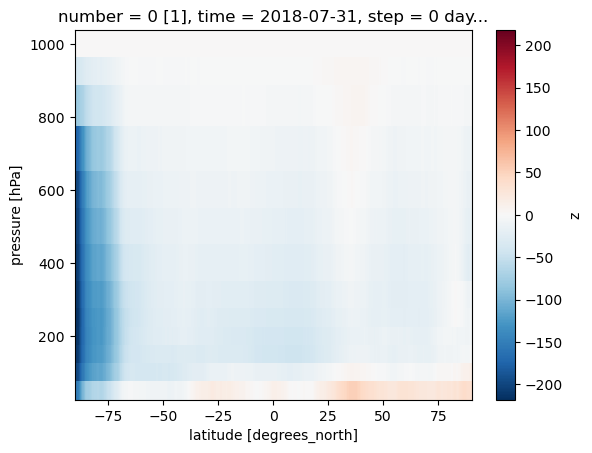

In [82]:
(z_diff/10).mean('longitude').plot()

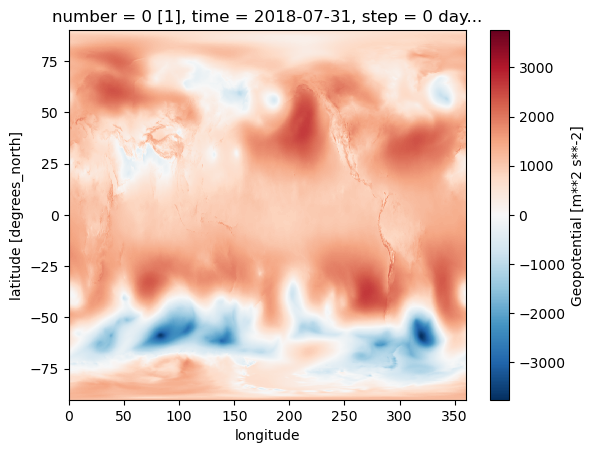

In [83]:
z_adjust.sel(level=1000).plot()

()

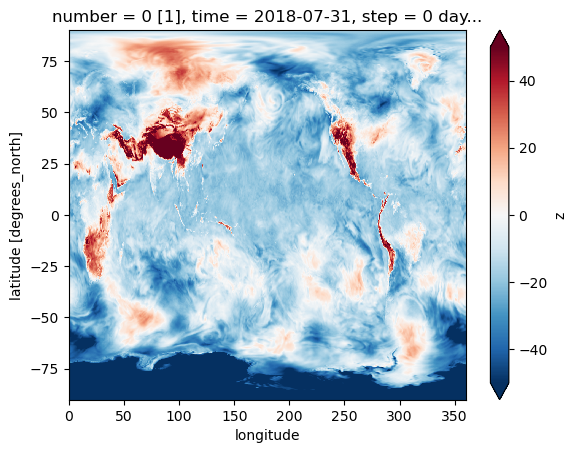

In [87]:
(z_diff/9.806).sel(level=600).plot(vmin=-50,vmax=50,cmap='RdBu_r')
()